In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 70
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os 
%matplotlib inline

In [4]:
sns.set_style('darkgrid')

NewColName = ["id","age","sexe","nationalite","etudiant_IMT","musique/Replique",
              "sw_rep_1", "sw_rep_2","ter_mus_1","ter_mus_2","rl_rep_1","rl_rep_2",
             "tit_mus_1","tit_mus_2","sw_mus_1","sw_mus_2","tit_rep_1","tit_rep_2",
             "rl_mus_1","rl_mus_2","lotr_mus_1","lotr_mus_2","ter_rep_1","ter_rep_2",
             "lotr_rep_1","lotr_rep_2","sw_nbr_vis", "sw_age_vis","rl_nbr_vis","rl_age_vis",
             "tit_nbr_vis","tit_age_vis","lotr_nbr_vis","lotr_age_vis","ter_nbr_vis","ter_age_vis",
             "répliques","musique","histoire","revoir_film","enfance","emotion"]


# ### Clean de sw_rep_2

unknown = "unknown"
known = "known"

In [5]:
def repplace(dataset,colname, value):
    for k in value :
        dataset[colname] = dataset[colname].apply(lambda var : known if k in var.lower() else var)
    
def finalize(dataset,colname):
    l = dataset[colname].unique()
    l = l[l != known]
    l = l[l != unknown]
    dataset[colname] = dataset[colname].apply(lambda var : unknown if var in (l) else var)



dictt = {"ter_mus_2": ["terminator"] ,
         "rl_mus_2":['roi lion',"roo lion","roi lyon","lion king","le roi loin","prince tigre",'nakouna matata'],
         'sw_mus_2': ["star wars","empire","sw","starwar","star wa","guerre ","stawar","stars wa","starwax","jeudi"],
        'lotr_mus_2': ["seigneur des anneaux","lord of the ring","seigneur","la meilleure","lotr","communauté de l'anneau"," avec les orcs et les nains","hobbit"],
        'tit_mus_2': ["titanic","bateau","tani"],
         "ter_rep_2": ["terminator","termiantor","governator","robot"] ,
         "rl_rep_2":['roi lion',"AKUMANATAT".lower(),"roi lyon","lion king","roi l","akouna mata","matata"],
        'lotr_rep_2':  ["seigneur des anneaux","lord of the ring","seigneur","la meilleure","lotr","communauté de l'anneau"," avec les orcs et les nains","hobbit","GO BACK".lower(),"senior","fellowship"],
        'tit_rep_2': ["titanic","bateau","tani"],
        }

In [6]:

def clean_data(dictt,NewColName):

	dataset = pd.read_csv("resultsOfSurvey.csv", sep= ",")

	# Le fichier ne contient que des réponses complètes, nous pouvont donc drop la colonne "Completed" qui est tout le temps égale à Y  
	# Les colonnes 0001.14, 0004.1, 0007, 0010 et 0013 sont hors de propos
	dataset.drop("Completed", axis =1, inplace = True) 
	dataset.drop(["0001.14", "0004.1", "0007", "0010","0013"], axis =1, inplace = True) 

	# Ici : 
	# - 1 --> Est ce que vous connaissez la réplique /musique
	# - 2 --> Le nom du film associé
	# - rep --> Réplique
	# - mus --> Musique
	# - nbr_vis --> Nombre de visionage
	# 
	# Modification des colonnes
	dataset.set_axis(NewColName, axis = 1, inplace= True)
	
	# ### Drop des réponses troll 
	dataset.drop(dataset[dataset["id"] == 84].index, axis =0, inplace = True) 
	dataset.drop(dataset[dataset["id"] == 16].index, axis =0, inplace = True) 

	dataset["sw_rep_2"].fillna(value = unknown, inplace = True)
	dataset["sw_rep_2"] = dataset["sw_rep_2"].apply(lambda var : known if 'star wars' in var.lower() else var)

	repplace(dataset,"sw_rep_2",["empire","jedi","guerre","starwars","stars wars","star war","stars war"])
	finalize(dataset,"sw_rep_2")


	for k in dictt :
	    dataset[k].fillna(value = unknown, inplace = True)
	    repplace(dataset,k,dictt[k])
	    finalize(dataset , k)

	return dataset

In [7]:
def create_stat_df(dataset):

	#dataset.to_csv('cleaned.csv')
	testKhi2 = ['répliques','musique','histoire','revoir_film','enfance','emotion']
	df = dataset.loc[:,testKhi2]
	
	stat_dict = {}
	for key in testKhi2:
		unique, counts = np.unique(df[key], return_counts=True)
		values = list(counts)
		reponses = list(unique)
		print(dict(zip(unique,counts)))
		stat_dict[key] = values

	# Réarrangement des index des lignes dans cet ordre: d'accord / plutot d'accord / neutre / plutot pas d'accord / pas d'accord
	neutre,pdc,dc,ppdc = reponses[1],reponses[2],reponses[3],reponses[4]
	reponses[1],reponses[2],reponses[3],reponses[4] = dc,neutre,ppdc,pdc
	
	# On créer le dataframe et on change les noms des lignes par les valeurs de la liste reponse 	
	df_stat = pd.DataFrame(stat_dict)
	df_stat['réponses'] = reponses
	df_stat = df_stat.set_index('réponses')
	print(df_stat)

	df_stat.to_csv('khi_carre.csv')

	# On montre un aperçu des principaux trucs statistiques
	print('\nDescriptions')
	print(df_stat.describe())

	return df_stat,reponses,testKhi2

In [10]:
def creating_count_plot(df_stat,reponses):

	plt.figure('mainplot',figsize=(10,10))
	for i,attribute in enumerate(testKhi2):
		plt.subplot(3,2,i+1)
		sns.countplot(x=attribute,data=dataset,order=reponses)
	plt.tight_layout()
	namefile = "countplot.png"
	# savename = os.path.join(savingpath,namefile)
	plt.show()
	# plt.savefig(savename)
	# plt.close('mainplot')

{"D'accord": 172, 'Neutre': 35, "Pas d'accord": 6, "Plutôt d'accord": 79, "Plutôt pas d'accord": 8}
{"D'accord": 223, 'Neutre': 10, "Pas d'accord": 5, "Plutôt d'accord": 60, "Plutôt pas d'accord": 2}
{"D'accord": 205, 'Neutre': 17, "Pas d'accord": 5, "Plutôt d'accord": 68, "Plutôt pas d'accord": 5}
{"D'accord": 128, 'Neutre': 45, "Pas d'accord": 13, "Plutôt d'accord": 95, "Plutôt pas d'accord": 19}
{"D'accord": 30, 'Neutre': 97, "Pas d'accord": 51, "Plutôt d'accord": 59, "Plutôt pas d'accord": 63}
{"D'accord": 127, 'Neutre': 42, "Pas d'accord": 5, "Plutôt d'accord": 116, "Plutôt pas d'accord": 10}
                     répliques  musique  histoire  revoir_film  enfance  \
réponses                                                                  
D'accord                   172      223       205          128       30   
Plutôt d'accord             35       10        17           45       97   
Neutre                       6        5         5           13       51   
Plutôt pas d'accord 

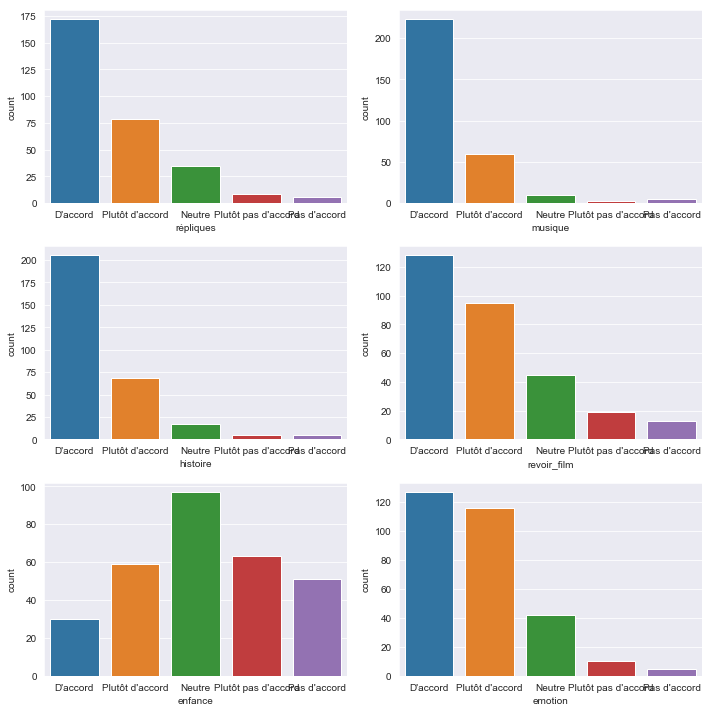

In [11]:
dataset = clean_data(dictt,NewColName)

df_stat,reponses,testKhi2 = create_stat_df(dataset)

creating_count_plot(df_stat,reponses)